## Sagnac Frequency - Backscatter Correction - Mulit-Regression Model

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.load_beam_wander_data import __load_beam_wander_data
from functions.reduce import __reduce
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "Z"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

mod = "df3"
config['file'] = f"multi_regression_R{config['ring']}_{mod}.pkl"

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


## Methods

In [4]:
def __makeplot_corr_matrix(ddf, target, m="pearson"):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    _df = ddf.copy()

    if "time" in list(_df.columns):
        _df.drop(columns="time", inplace=True)

    _df = _df.iloc[:, :]

    corr = _df.corr(method=m)

    # mask upper triangle
    corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

    print(corr)

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
    cmap = plt.get_cmap("coolwarm", 9)

    # Generate a mask for the upper triangle
    # mask = np.zeros_like(corr, dtype=bool)
    # mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    # sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

    im = plt.pcolor(corr, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    plt.colorbar(im, extend="both")

    labels = list(corr.columns)
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels))+0.5)
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(len(labels))+0.5)
    ax.set_yticklabels(labels)


    fig.suptitle(f'{m} correlation matrix', fontsize=15)

    fig.tight_layout();

    return fig

In [5]:
def __find_model(ddf, _features, target="fj_fs", reg="theilsen"):

    from sklearn import linear_model
    from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor

    _df = ddf.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    print(_features)

    # define x data
    X = _df[_features].values.reshape(-1, len(_features))

    # define y data
    y = _df[target].values

    # multi linear regression

    # using OLS
    if reg.lower() == "ols":
        ols = linear_model.LinearRegression()
        model = ols.fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    elif reg.lower() == "ransac":
        model = RANSACRegressor(random_state=1).fit(X, y)
        print("R2:", model.score(X, y))
        print("IC: ", model.estimator_.intercept_)
        print("Coef: ",  model.estimator_.coef_)
        for _f, _c in zip(_features, model.estimator_.coef_):
            print(f"{_f} : {_c}")

    # using TheilSen
    elif reg.lower() == "theilsen":
        model = TheilSenRegressor().fit(X, y)

        print("R2:", model.score(X, y))
        print("X0:",  model.intercept_)
        print("Coef: ",  model.coef_)
        for _f, _c in zip(_features, model.coef_):
            print(f"{_f} : {_c}")

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(model.predict(x_pred))

    out = {}
    out['model'] = model
    out['r2'] = model.score(X, y)
    out['tp'] = _df.time
    out['dp'] = model_predict

    # plt.plot(_df.time, model_predict)
    # plt.plot(_df.time, _df[target].values)

    return out

In [6]:
def __predict_data(df_in, _features, _model, target="fj_fs"):

    from numpy import array

    _df = df_in.copy()

    # remove time and target
    try:
        _features.remove(target)
    except:
        pass
    try:
        _features.remove("time")
    except:
        pass

    # prediction
    model_predict = []

    for o, row in _df[_features].iterrows():

        x_pred = []
        for feat in _features:
            x_pred.append(row[feat])

        x_pred = np.array(x_pred)
        x_pred = x_pred.reshape(-1, len(_features))

        model_predict.append(_model.predict(x_pred))

    return array(_df.time), array(model_predict)

In [7]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df[target], color="k", label="observed")
    ax.plot(df0.time*tscale, modell['dp'], color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"$\Delta$f (Hz)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.2f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [8]:
def __makeplot2(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    if target == "bwy":
        ax.set_ylim(-0.01, 0.055)
    if target == "bwx":
        ax.set_ylim(-0.002, 0.005)

    ax.set_title(target)

    plt.show();
    return fig

### Read Dataframe

In [9]:
df = read_pickle(config['path_to_out_data']+config['file'])

In [10]:
df['fj_bs'] = __interpolate_nan(__smooth(df.fj_bs, 30))
df['fj_fs'] = __interpolate_nan(__smooth(df.fj_fs, 30))
df['fj_bs_dj'] = __interpolate_nan(__smooth(df.fj_bs_dj, 30))

### Define features

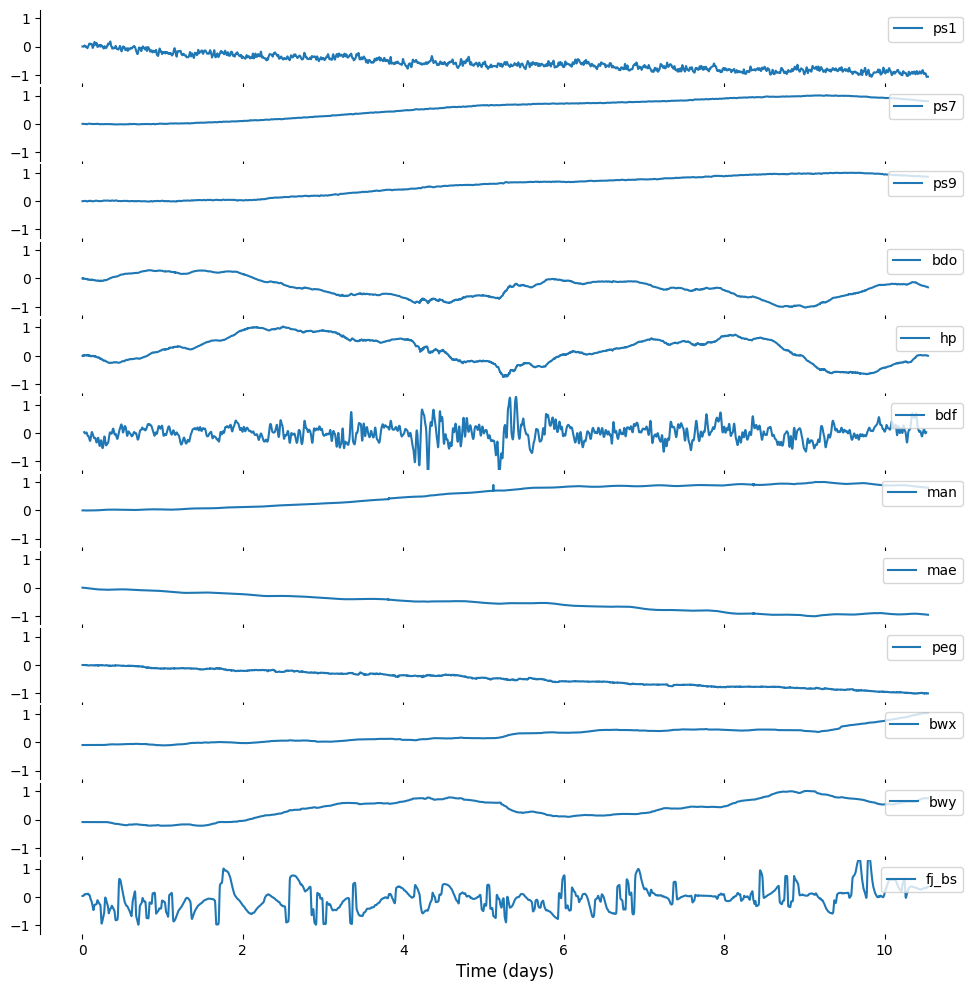

In [11]:
def __makeplot(_df):

    import matplotlib.pyplot as plt

    blocked = ["time", "fj_fs", "fj_bs_dj"]
    keys = [k for k in _df.keys() if k not in blocked ]

    Nrow, Ncol = len(keys), 1

    tscale = 1/86400

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.05)

    for i, k in enumerate(keys):

        ax[i-1].plot(_df.time*tscale, _df[k]/np.nanpercentile(abs(_df[k]), 99), label=k)

    for i in range(Nrow):
        # ax[i].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[i].set_ylim(-1.3, 1.3)
        ax[i].legend(loc=1)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)

    ax[Nrow-1].set_xlabel(f"Time (days)", fontsize=font)

    plt.show();
    return fig

fig = __makeplot(df);

fig.savefig(config['path_to_figs']+f"SF_RV_{mod}_data.png", format="png", dpi=150, bbox_inches='tight')


In [12]:
# for k in df.keys():
#     print(k)
#     plt.figure(figsize=(15, 5))
#     plt.plot(df[k])
#     plt.show();

In [13]:
def __makeplot1(df0, df1, df2,
                tp1, dp1, model1, target1,
               ):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from numpy import array

    def __corr(df_in, m="kendall", targetx="not_the_one"):

        _df = df_in.copy()

        if "time" in list(_df.columns):
            _df.drop(columns="time", inplace=True)
        # if targetx in list(_df.columns):
        #     _df.drop(columns=targetx, inplace=True)


        _df = _df.iloc[:, :]

        corr = _df.corr(method=m.lower())

        # mask upper triangle
        corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

        return corr

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        vr = round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)
        return vr


    # correlatin matrix
    c_method = "Kendall" # kendall pearson spearman
    corr1 = __corr(df0, m=c_method, targetx=target1)

    # variance reduction
    dat = array(df2[target1])
    res = dat - dp1
    VR = __variance_reduction(dat, res)

    # root mean square error
    rmse = __rmse(dat, dp1)

    # _________________________________________
    #

    yscale, yunit = 1e3, "mHz"

    tscale = 1/86400

    Nrow, Ncol = 1, 15

    cmap = plt.get_cmap("coolwarm", 9)

    fig = plt.figure(figsize=(15, 5))

    font = 12

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=1.2)

    ax0 = fig.add_subplot(gs[0, :10])
    ax1 = fig.add_subplot(gs[0, 10:])

    axes = [ax0, ax1]


    ax0.plot(df1.time*tscale, df1[target1]*yscale, color="k", label="observed (training)", alpha=0.7)
    ax0.plot(model1['tp']*tscale, array(model1['dp'])*yscale, color="tab:red", label="predicted (training)", alpha=0.7)

    ax0.fill_betweenx([-1000, 1000], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax0.plot(df2.time*tscale, df2[target1]*yscale, color="k", label="observed")
    ax0.plot(tp1*tscale, dp1*yscale, color="darkred", label="predicted")
    ax0.set_xlabel("Time (days)", fontsize=font)

    im1 = ax1.pcolor(corr1, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")

    labels = list(corr1.columns)
    # ax1.yaxis.set_label_position("right")
    # ax1.yaxis.tick_right()
    ax1.set_xticks(np.arange(len(labels))+0.5)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(len(labels))+0.5)
    # ax1.set_yticklabels(reversed(labels))
    ax1.set_yticklabels(labels)


    ax1.text(0.5, 0.97, f"{c_method} correlation", ha="center", va="top", transform=ax1.transAxes, fontsize=font-1)

    for ax in [ax0]:

        ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax.legend(loc=9, fontsize=font-2, ncol=2)
        ax.set_ylabel(f"$\Delta$f ({yunit})", fontsize=font)

    ax0.text(0.97, 0.27, f"R$^2$ = {model1['r2']:.3f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.text(0.97, 0.20, f"$\sigma_R$ = {VR:.2f}%", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.text(0.97, 0.12, f"RMSE = {rmse:.5f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)

    ax0.set_xlim(0, df2.time.max()*tscale)


    ax0.set_ylim(np.nanpercentile(df0[target1], 3)*yscale*2, np.nanpercentile(df0[target1], 97)*yscale*2)
    ax0.set_ylim(-1, 6)

    mod = ""
    for i, ll in enumerate(features_model):
        mod += f"c$_{i}$ ${ll}$ + "

    tit1 = f"{target1} = {mod}"
    ax0.set_title(tit1[:-2])

    axes = [ax0, ax1]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.01, .98, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig

In [14]:
# targetx = "fj_fs"
targetx = "fj_bs"
# targetx = "fj_bs_dj"

featuresx = ['time', targetx, 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

dfx = df[featuresx].copy()

N = dfx.shape[0]

df1_part1 = dfx.copy().iloc[:int(N*3/4)]
df1_part2 = dfx.copy().iloc[int(N*1/4):]

features_model = ['time', targetx, 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
# features_model = ['time', 'fj_bs', 'ps1', 'ps7', 'ps9']

out = __find_model(df1_part1, features_model, target=targetx, reg="ransac")

t_predict, d_predict = __predict_data(df1_part2, features_model, out['model'], target=targetx)


['bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: -0.17880615101146624
IC:  -0.001102249823988661
Coef:  [-1.11802616e+00  1.10032466e-02  1.22070615e-04  3.42363693e-04
 -5.13557366e-03 -1.14959783e-02  3.30302490e-02  1.42302950e+03
  1.62229178e+03  8.65858750e-02]
bwx : -1.1180261560277833
bwy : 0.011003246637576361
bdo : 0.00012207061543233547
hp : 0.0003423636931788272
ps1 : -0.005135573659341411
ps7 : -0.01149597826970264
ps9 : 0.03303024901253427
mae : 1423.0294966542456
man : 1622.291783437581
peg : 0.08658587498651944


/tmp/ipykernel_90866/3350292491.py:85: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(im1, cax=cbar_ax, extend="both")


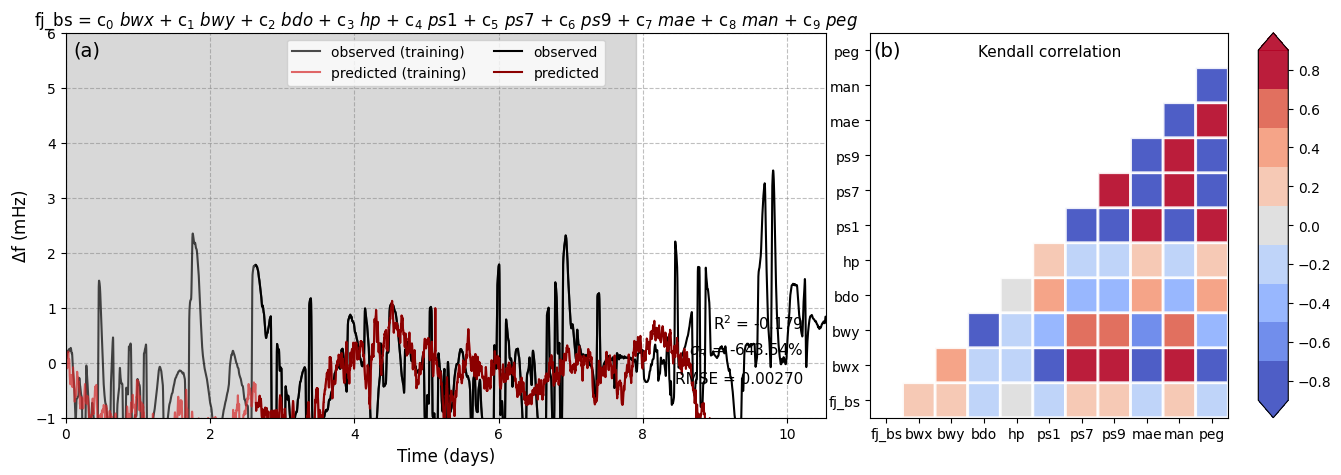

In [15]:
fig = __makeplot1(dfx, df1_part1, df1_part2,
                  t_predict, d_predict, out, targetx,
                  );

fig.savefig(config['path_to_figs']+f"SF_R{config['ring']}_sagnac_frequency_{mod}_model.png", format="png", dpi=150, bbox_inches='tight')

del fig

In [16]:
out = __find_model(dfx, features_model, target=targetx, reg="ransac")

t_predict, d_predict = __predict_data(dfx, features_model, out['model'], target=targetx)


['bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: -0.0004892902331739002
IC:  -0.0009488929799980515
Coef:  [ 3.97660655e-02  4.15624409e-01  3.36716780e-04  1.62843892e-05
  3.11132698e-03 -6.06935759e-03  4.07476128e-03 -1.80128880e+02
  1.94275897e+03  4.46749744e-02]
bwx : 0.03976606554610156
bwy : 0.4156244090397345
bdo : 0.00033671677993232785
hp : 1.628438924505815e-05
ps1 : 0.00311132697533219
ps7 : -0.006069357585665874
ps9 : 0.004074761280837988
mae : -180.12888040353346
man : 1942.758965187778
peg : 0.04467497444469543


In [17]:
gc.collect()

51950

In [18]:
pre = np.array([_d[0] for _d in d_predict])

bs = dfx.fj_bs.values

fcorrect = bs - pre

In [19]:
fcorrect = bs - pre

In [20]:
df.keys()

Index(['time', 'fj_fs', 'fj_bs', 'fj_bs_dj', 'ps1', 'ps7', 'ps9', 'bdo', 'hp',
       'bdf', 'man', 'mae', 'peg', 'bwx', 'bwy'],
      dtype='object')

3.16
0.86
0.82


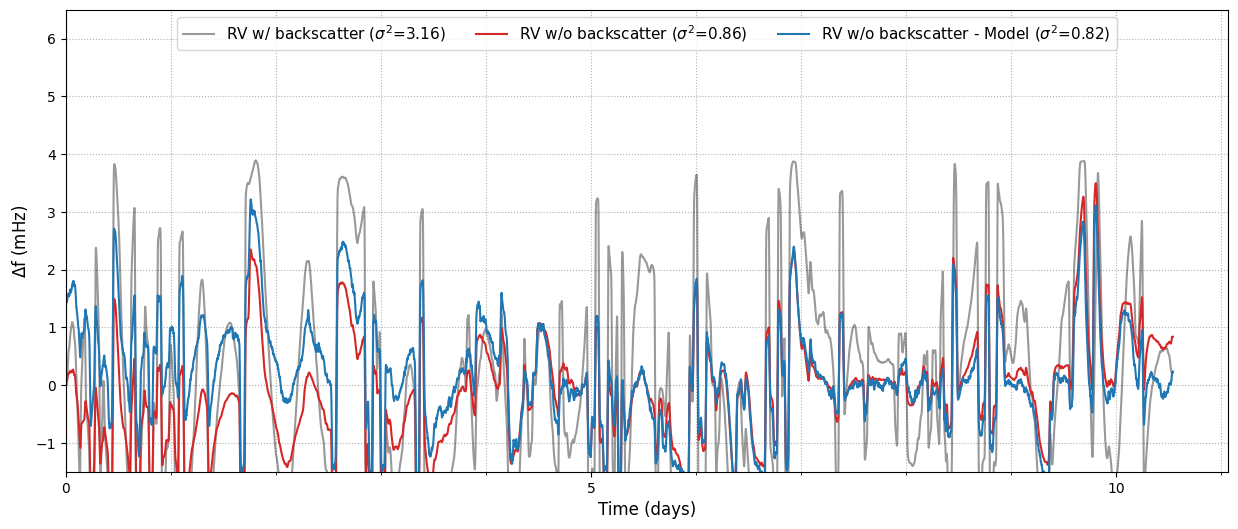

In [21]:
def __makeplot(_df, fcorrect):

    time = _df.time

    Nrow, Ncol = 1, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fscale, funit = 1e3, "mHz"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 6))

    dat1 = __reduce(_df.fj_fs, 10)*fscale
    dat2 = _df.fj_bs*fscale
    dat3 = fcorrect*fscale

    var1 = round(np.var(dat1), 2)
    print(var1)
    var2 = round(np.var(dat2), 2)
    print(var2)
    var3 = round(np.var(dat3), 2)
    print(var3)

    ax.plot(time*tscale, dat1, color="black", label=f"RV w/ backscatter ($\sigma^2$={var1})", alpha=0.4)
    ax.plot(time*tscale, dat2, color="tab:red", label=f"RV w/o backscatter ($\sigma^2$={var2})")
    ax.plot(time*tscale, dat3, color="tab:blue", label=f"RV w/o backscatter - Model ($\sigma^2$={var3})")

    ax.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax.set_xlabel(f"Time ({tunit})", fontsize=font)

    ax.set_ylim(-1.5, 6.5)

    ax.grid(ls=":", zorder=0, which="both")
    ax.legend(loc=9, ncol=3, fontsize=font-1)

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    ax.set_xlim(left=0)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    plt.show();
    return fig

fig = __makeplot(df, fcorrect);

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_{mod}_model_reduction.png", format="png", dpi=150, bbox_inches='tight')


In [22]:
df0 = read_pickle(config['path_to_out_data']+config['file'])

sps = 1/60


In [23]:
def get_allan(data, sps):

    import allantools

    # define tau range e.g. 5 (= 10⁵) and number of samples N
    upper = 6
    lower = -4
    N = 150

    # list of tau values in seconds
    taux = np.logspace(lower, upper, N)

    #compute allan
    allan = allantools.oadev(data,
                             data_type='freq',
                             rate=sps,
                             taus='all', # all, octave, decade
                             )

    return np.array(allan[0]), np.array(allan[1]), np.array(allan[2])


In [24]:
tau1, adev1, err1 = get_allan(df0.fj_fs/447.728, sps)
tau2, adev2, err2 = get_allan(df0.fj_bs/447.728, sps)
tau3, adev3, err3 = get_allan(fcorrect/447.728, sps)

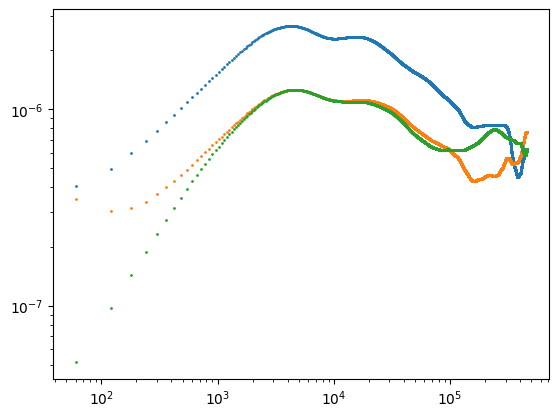

In [25]:
plt.scatter(tau1, adev1, s=1)
plt.scatter(tau2, adev2, s=1)
plt.scatter(tau3, adev3, s=1)
plt.xscale("log")
plt.yscale("log")

/tmp/ipykernel_90866/2983644586.py:53: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(left=0)


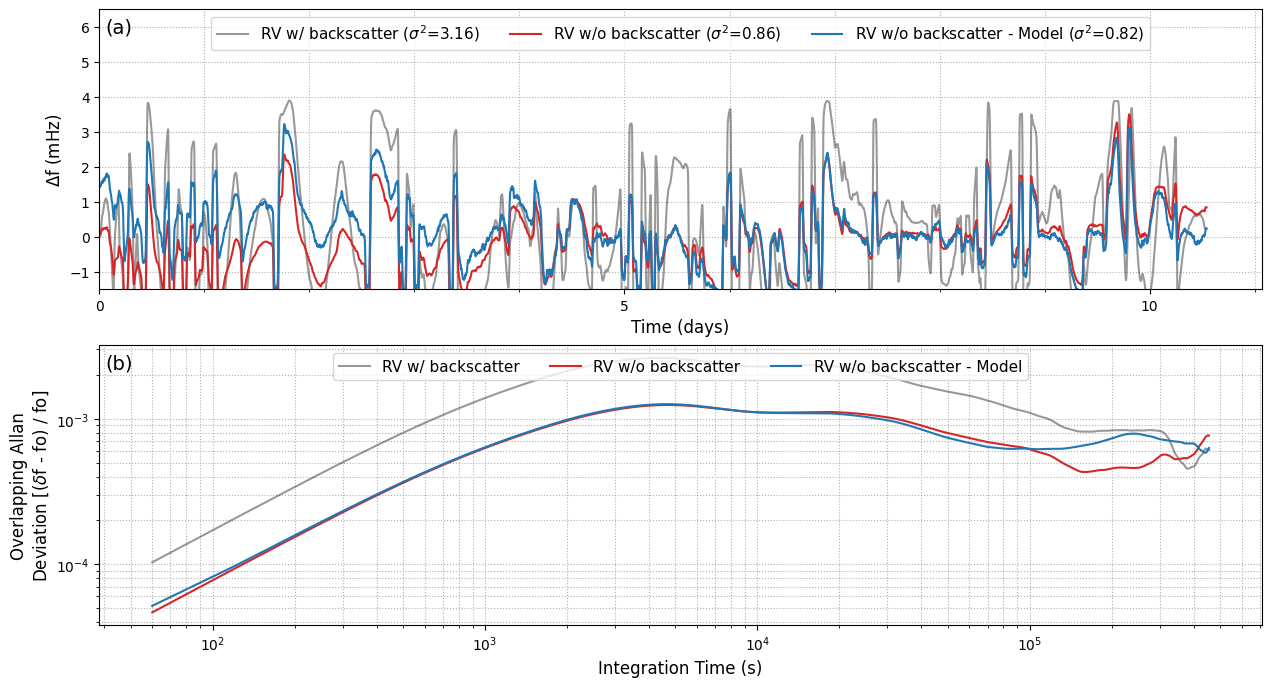

In [26]:
def __makeplot(_df, fcorrect, fs0=447.728, sps=1/60):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    time = _df.time

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fscale, funit = 1e3, "mHz"

    fig, (ax1, ax2) = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    dat1 = __reduce(_df.fj_fs, 10)*fscale
    dat2 = _df.fj_bs*fscale
    dat3 = fcorrect*fscale

    var1 = round(np.var(dat1), 2)
    var2 = round(np.var(dat2), 2)
    var3 = round(np.var(dat3), 2)

    ax1.plot(time*tscale, dat1, color="black", label=f"RV w/ backscatter ($\sigma^2$={var1})", alpha=0.4)
    ax1.plot(time*tscale, dat2, color="tab:red", label=f"RV w/o backscatter ($\sigma^2$={var2})")
    ax1.plot(time*tscale, dat3, color="tab:blue", label=f"RV w/o backscatter - Model ($\sigma^2$={var3})")

    ax1.set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax1.set_xlabel(f"Time ({tunit})", fontsize=font)

    ax1.set_ylim(-1.5, 6.5)

    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))


    tau1, adev1, err1 = get_allan(dat1/fs0, sps)
    tau2, adev2, err2 = get_allan(dat2/fs0, sps)
    tau3, adev3, err3 = get_allan(dat3/fs0, sps)

    ax2.plot(tau1, adev1, color="black", label=f"RV w/ backscatter", alpha=0.4)
    ax2.plot(tau2, adev2, color="tab:red", label=f"RV w/o backscatter")
    ax2.plot(tau3, adev3, color="tab:blue", label=f"RV w/o backscatter - Model")

    ax2.set_xscale("log")
    ax2.set_yscale("log")

    ax2.set_ylabel(f"Overlapping Allan\nDeviation [($\delta$f - fo) / fo]", fontsize=font)
    ax2.set_xlabel(f"Integration Time (s)", fontsize=font)

    for ax in [ax1, ax2]:
        ax.set_xlim(left=0)
        ax.grid(ls=":", zorder=0, which="both")
        ax.legend(loc=9, ncol=3, fontsize=font-1)


    axes = [ax1, ax2]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)

    plt.show();
    return fig

fig = __makeplot(df, fcorrect, fs0=447.728, sps=1/60);

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_{mod}_model_reduction_allan.png", format="png", dpi=150, bbox_inches='tight')


### RUN as loop to test stability

In [27]:
# for i in range(10):
#     print(i)

#     out = __find_model(df1_part1, features_model, target=targetx, reg="ransac")

#     t_predict, d_predict = __predict_data(df1_part2, features_model, out['model'], target=targetx)

#     fig = __makeplot3(dfx, df1_part1, df1_part2,
#                       t_predict, d_predict, out, targetx,
#                       );

In [28]:
# fig = __makeplot(dfx, out, targetx);

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_shortterm_model_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


In [29]:
# fig = __makeplot_corr_matrix(dfx, targetx, m="pearson")

# fig.savefig(config['path_to_figs']+f"BW_ccmatrix_{config['tbeg'].date}_{config['tend'].date}_.png", format="png", dpi=150, bbox_inches='tight')


## Modelling

### Beam Wander

## Both Components

In [30]:

features = ['time', 'bwx', 'bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

df1 = df[features]

# get size of frame
N = df1.shape[0]

# split frame in two parts
df1_part1 = df1.iloc[:int(N/2)]
df1_part2 = df1.iloc[int(N/2):]

# set feature to model
target1 = "bwy"

# features1 = ['bwy', 'bdo', 'hp', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
features1 = ['bwy', 'bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man']

# find model with first part of frame
out_y = __find_model(df1_part1, features1, target=target1, reg="ransac")

# predict data for second part of frame
t_predict_y, d_predict_y = __predict_data(df1_part2, features1, out_y['model'], target=target1)


# fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig = __makeplot2(df1_part1, df1_part2, t_predict_y, d_predict_y, out_y, target1);



# set feature to model
target2 = "bwx"

# features2 = ['bwx', 'bdo', 'hp',  'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
features2 = ['bwx', 'ps7', 'ps9', 'mae', 'man', 'peg']


# find model with first part of frame
out_x = __find_model(df1_part1, features2, target=target2, reg="ransac")

# predict data for second part of frame
t_predict_x, d_predict_x = __predict_data(df1_part2, features2, out_x['model'], target=target2)


# fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig = __makeplot2(df1_part1, df1_part2, t_predict_x, d_predict_x, out_x, target2);


['bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man']
R2: 0.9917338085733779
IC:  -0.0008140974009229847
Coef:  [-6.01797272e-04 -8.96276267e-03  2.63119170e-02 -1.30562375e-03
 -1.05897597e+03 -6.90118364e+03]
bdo : -0.0006017972723853333
ps1 : -0.008962762665371252
ps7 : 0.02631191698162669
ps9 : -0.001305623746503233
mae : -1058.9759662886418
man : -6901.183640118435
['ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9152923496197242
IC:  -0.001097279707978449
Coef:  [-6.03959796e-03  6.16733233e-03 -1.22159578e+03  2.33676931e+02
  5.44897823e-03]
ps7 : -0.006039597957748024
ps9 : 0.006167332330485364
mae : -1221.5957823081512
man : 233.6769311951002
peg : 0.005448978227251239


/tmp/ipykernel_90866/753793378.py:71: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(im1, cax=cbar_ax, extend="both")


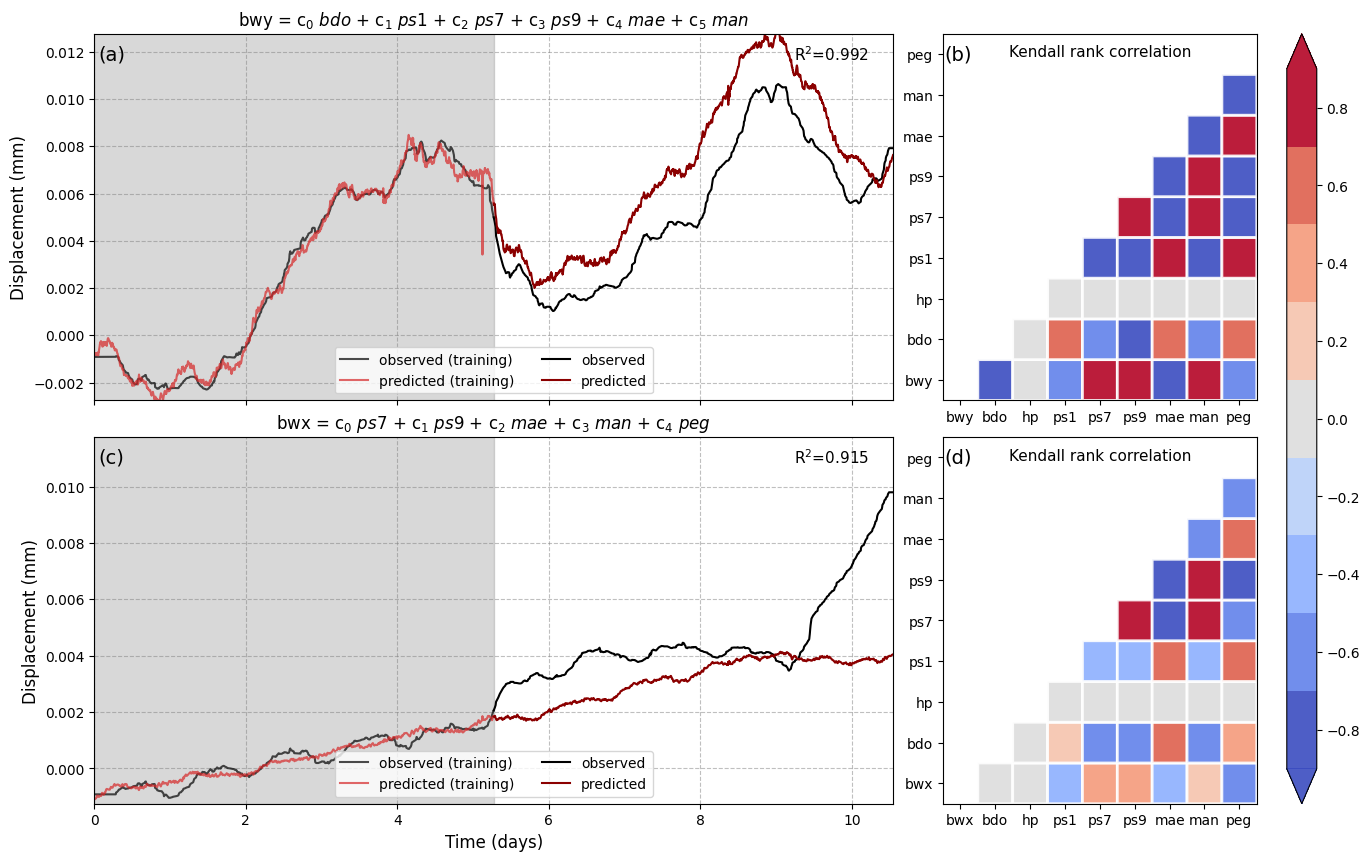

In [31]:
def __makeplot3(df0, df1, df2,
                tp1, dp1, model1, target1,
                tp2, dp2, model2, target2
               ):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    def __corr(df_in, m="kendall", targetx="not_the_one"):

        _df = df_in.copy()

        if "time" in list(_df.columns):
            _df.drop(columns="time", inplace=True)
            _df.drop(columns=targetx, inplace=True)

        _df = _df.iloc[:, :]

        corr = _df.corr(method=m.lower())

        # mask upper triangle
        corr[:] = np.where(np.arange(corr.shape[0])[:, None] >= np.arange(corr.shape[1]), np.nan, corr)

        return corr

    c_method = "Kendall" # kendall pearson spearman


    corr1 = __corr(df1, m=c_method, targetx=target2)

    corr2 = __corr(df2, m=c_method, targetx=target1)


    # _________________________________________
    #

    tscale = 1/86400

    Nrow, Ncol = 2, 10

    cmap = plt.get_cmap("coolwarm", 9)

    fig = plt.figure(figsize=(15, 10))

    font = 12

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.1, wspace=0.7)

    ax0 = fig.add_subplot(gs[0, :7])
    ax1 = fig.add_subplot(gs[0, 7:])
    ax2 = fig.add_subplot(gs[1, :7])
    ax3 = fig.add_subplot(gs[1, 7:])

    axes = [ax0, ax1, ax2, ax3]


    ax0.plot(df1.time*tscale, df1[target1], color="k", label="observed (training)", alpha=0.7)
    ax0.plot(model1['tp']*tscale, model1['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax0.fill_betweenx([-1000, 1000], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax0.plot(df2.time*tscale, df2[target1], color="k", label="observed")
    ax0.plot(tp1*tscale, dp1, color="darkred", label="predicted")

    ax0.set_xticklabels([])

    im1 = ax1.pcolor(corr1, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im1, cax=cbar_ax, extend="both")

    labels = list(corr1.columns)
    # ax1.yaxis.set_label_position("right")
    # ax1.yaxis.tick_right()
    ax1.set_xticks(np.arange(len(labels))+0.5)
    ax1.set_xticklabels(labels)
    ax1.set_yticks(np.arange(len(labels))+0.5)
    # ax1.set_yticklabels(reversed(labels))
    ax1.set_yticklabels(labels)

    ax1.text(0.5, 0.97, f"{c_method} rank correlation", ha="center", va="top", transform=ax1.transAxes, fontsize=font-1)

    ax2.plot(df1.time*tscale, df1[target2], color="k", label="observed (training)", alpha=0.7)
    ax2.plot(model2['tp']*tscale, model2['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax2.fill_betweenx([df0[target2].min()*1.2, df0[target2].max()*1.2], df1.time.min()*tscale, df1.time.max()*tscale, color="grey", alpha=0.3)

    ax2.plot(df2.time*tscale, df2[target2], color="k", label="observed")
    ax2.plot(tp2*tscale, dp2, color="darkred", label="predicted")


    im2 = ax3.pcolor(corr2, cmap=cmap, vmin=-.9, vmax=.9, edgecolors='w', linewidths=2, alpha=0.9)
    # plt.colorbar(im2, extend="both")

    labels = list(corr2.columns)
    # ax3.yaxis.set_label_position("right")
    # ax3.yaxis.tick_right()
    ax3.set_xticks(np.arange(len(labels))+0.5)
    ax3.set_xticklabels(labels)
    ax3.set_yticks(np.arange(len(labels))+0.5)
    ax3.set_yticklabels(labels)

    ax3.text(0.5, 0.97, f"{c_method} rank correlation", ha="center", va="top", transform=ax3.transAxes, fontsize=font-1)


    for ax in [ax0, ax2]:

        ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax.legend(loc=8, fontsize=font-2, ncol=2)
        ax.set_ylabel(f"Displacement (mm)", fontsize=font)

    ax0.text(0.97, 0.97, f"R$^2$={model1['r2']:.3f}", ha="right", va="top", transform=ax0.transAxes, fontsize=font-1)
    ax2.text(0.97, 0.97, f"R$^2$={model2['r2']:.3f}", ha="right", va="top", transform=ax2.transAxes, fontsize=font-1)

    ax0.set_xlim(0, df2.time.max()*tscale)
    ax2.set_xlim(0, df2.time.max()*tscale)

    # ax0.set_ylim(-0.01, 0.055)
    # ax2.set_ylim(-0.002, 0.005)

    ax0.set_ylim(df0[target1].min()*1.2, df0[target1].max()*1.2)
    ax2.set_ylim(df0[target2].min()*1.2, df0[target2].max()*1.2)

    mod = ""
    for i, ll in enumerate(features1):
        mod += f"c$_{i}$ ${ll}$ + "

    tit1 = f"{target1} = {mod}"
    ax0.set_title(tit1[:-2])

    mod = ""
    for i, ll in enumerate(features2):
        mod += f"c$_{i}$ ${ll}$ + "

    tit2 = f"{target2} = {mod}"
    ax2.set_title(tit2[:-2])

    ax2.set_xlabel(f"Time (days)", fontsize=font)


    axes = [ax0, ax1, ax2, ax3]
    for _k, (ax, ll) in enumerate(zip(axes, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    plt.show();
    return fig


fig = __makeplot3(df1, df1_part1, df1_part2,
                  t_predict_y, d_predict_y, out_y, target1,
                  t_predict_x, d_predict_x, out_x, target2,
                  );

fig.savefig(config['path_to_figs']+f"SF_R{config['ring']}_beamwander_{mod}_model.png", format="png", dpi=150, bbox_inches='tight')


In [32]:
def __makeplot(df0, modell, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed")
    ax.plot(modell['tp']*tscale, modell['dp'], color="tab:red", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=4, fontsize=font-2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={modell['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(min(df0.time*tscale), max(df0.time*tscale))

    ax.set_title(target)

    plt.show();
    return fig

In [33]:

features = ['time', 'bwx', 'bwy', 'bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']

df1 = df[features]

target = "bwy"

N = df1.shape[0]

df1_part1 = df1.iloc[:int(N/2)]
df1_part2 = df1.iloc[int(N/2):]

out = __find_model(df1, features, target=target, reg="ransac")

t_predict, d_predict = __predict_data(df1_part2, features, out['model'], target=target)


['bwx', 'bdo', 'ps1', 'ps7', 'ps9', 'mae', 'man', 'peg']
R2: 0.9904446058564101
IC:  0.00020566601582019993
Coef:  [ 4.09694863e-01 -9.27139951e-04 -2.91646746e-02  1.79156086e-02
 -9.86484036e-03  1.40699627e+03 -3.79938121e+03 -8.39100588e-02]
bwx : 0.4096948631831776
bdo : -0.0009271399513868963
ps1 : -0.02916467461323432
ps7 : 0.017915608566065857
ps9 : -0.009864840358909737
mae : 1406.9962740717158
man : -3799.381213445867
peg : -0.08391005884380077


     bwx       bwy       bdo       ps1       ps7       ps9       mae  \
bwx  NaN  0.682086 -0.606216 -0.676422  0.794789  0.823653 -0.763260   
bwy  NaN       NaN -0.870780 -0.601449  0.755140  0.762787 -0.749628   
bdo  NaN       NaN       NaN  0.568283 -0.687548 -0.701762  0.695846   
ps1  NaN       NaN       NaN       NaN -0.735246 -0.700571  0.747840   
ps7  NaN       NaN       NaN       NaN       NaN  0.896851 -0.900973   
ps9  NaN       NaN       NaN       NaN       NaN       NaN -0.846907   
mae  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
man  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
peg  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          man       peg  
bwx  0.812738 -0.749995  
bwy  0.738733 -0.665059  
bdo -0.669355  0.607899  
ps1 -0.750910  0.742413  
ps7  0.941019 -0.862507  
ps9  0.906467 -0.815181  
mae -0.919209  0.876848  
man       NaN -0.879136  
peg       NaN       NaN  


/tmp/ipykernel_90866/3102599813.py:37: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(im, extend="both")


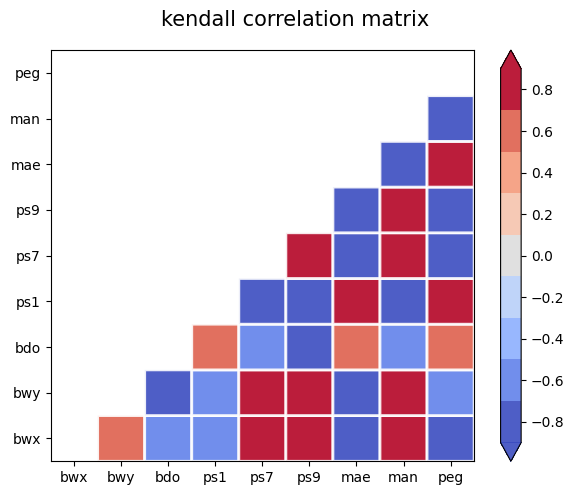

In [34]:
fig = __makeplot_corr_matrix(df1_part1, target, m="kendall")

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_ccmatrix.png", format="png", dpi=150, bbox_inches='tight')


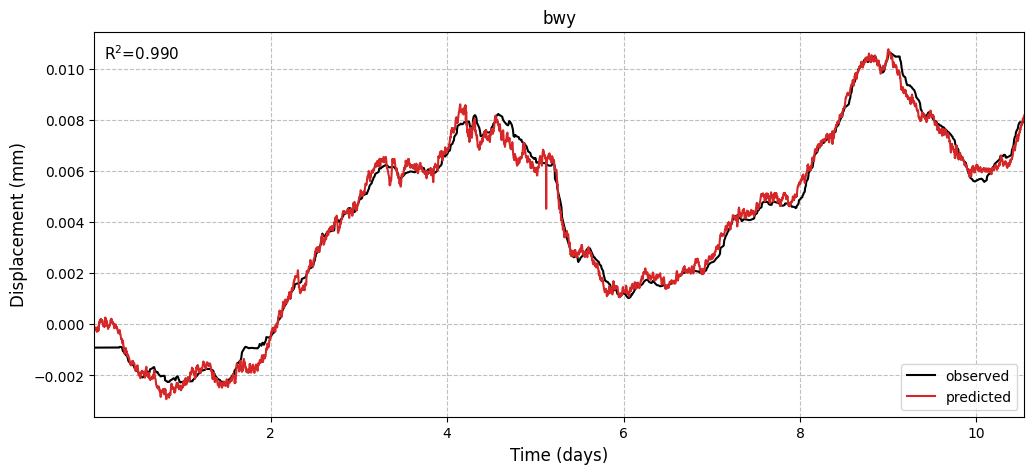

In [35]:
fig = __makeplot(df1, out, target)

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_beamwander_{target}_predicted.png", format="png", dpi=150, bbox_inches='tight')


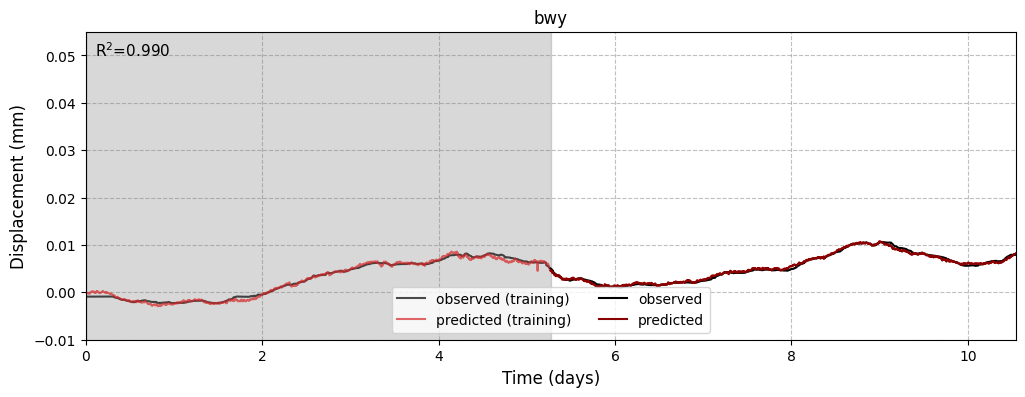

In [36]:
fig = __makeplot2(df1_part1, df1_part2, t_predict, d_predict, out, target);

In [37]:
def __makeplot_overview(df0, df1, tp, dp, model, target):

    import matplotlib.pyplot as plt

    tscale = 1/86400

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 4), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax.plot(df0.time*tscale, df0[target], color="k", label="observed (training)", alpha=0.7)
    ax.plot(model['tp']*tscale, model['dp'], color="tab:red", label="predicted (training)", alpha=0.7)

    ax.fill_betweenx([-1000, 1000], df0.time.min()*tscale, df0.time.max()*tscale, color="grey", alpha=0.3)

    ax.plot(df1.time*tscale, df1[target], color="k", label="observed")
    ax.plot(tp*tscale, dp, color="darkred", label="predicted")

    ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    ax.legend(loc=8, fontsize=font-2, ncol=2)

    ax.set_ylabel(f"Displacement (mm)", fontsize=font)
    ax.set_xlabel("Time (days)", fontsize=font)

    ax.text(0.01, 0.97, f"R$^2$={out['r2']:.3f}", ha="left", va="top", transform=ax.transAxes, fontsize=font-1)

    ax.set_xlim(0, df1.time.max()*tscale)

    ax.set_ylim(-0.01, 0.055)

    ax.set_title(target)

    plt.show();
    return fig

# __makeplot_overview(df0, df1, tp, dp, model, target)


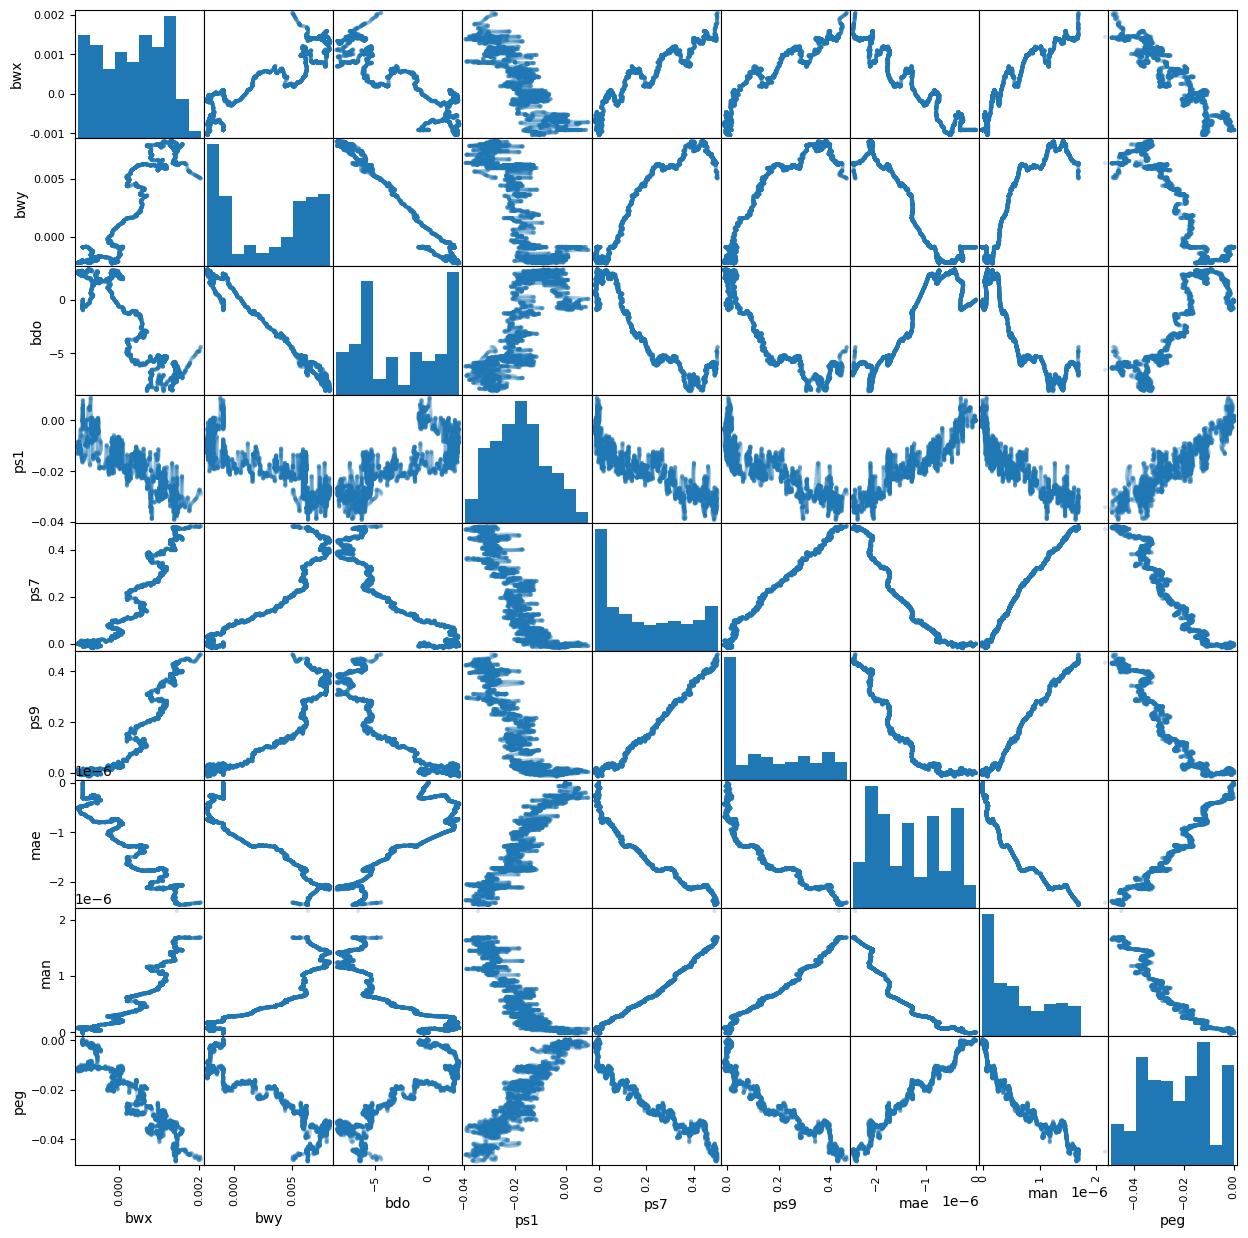

In [38]:
pd.plotting.scatter_matrix(df1_part1,
                           figsize=(15, 15),
                           alpha=0.2,
                           diagonal="hist",
                          );


### 